# Practical 4: Visualizing and quantifying genomic variation in real data


At the end of this practical you should:
- Know the following bioinformatic file formats and understand by which processes they can be generated
    - [FASTA format](https://en.wikipedia.org/wiki/FASTA_format)
    - [BED format](https://en.wikipedia.org/wiki/BED_(file_format))
    - [SAM/BAM format](https://en.wikipedia.org/wiki/SAM_(file_format) ) (for detailed specifications, see [here](https://samtools.github.io/hts-specs/SAMv1.pdf))
    - [VCF format](https://en.wikipedia.org/wiki/Variant_Call_Format) (for detailed specifications, see [here](https://samtools.github.io/hts-specs/VCFv4.2.pdf))
    
    
- Understand how (population) genomic data can be represented through these file formats.
    - **genomes** are usually represented through a single (haploid) consensus sequence in FASTA format
    - **regions of interest** (Exons, Introns, Telomeres, Transposable Elements, etc) are usually represented via annotation files in BED format
    - **variation** data is "called" based on BAM files and is usually recorded in VCF files. 
    
    
- Know that the analysis of variation data often requires additional simplifications and/or re-classification of the data:
    - usually **only SNPs (Single Nucleotide Polymorphisms) are analysed**, more complex variants are often ignored or discarded
    - the phase of genotypes of diploid/polyploid samples can be known (i.e. the membership of alleles on haplotypes is known), or not. Data is therefore referred to as **phased or unphased genotypes (GTs)**    
    - **patterns of variation can differ between genomic partitions** (CDS, introns, intergenic, synonymous/non-synonymous third codon positions, ...), which makes certain stratification of the analysis of these regions interesting and sometimes even essential. 
    
- Be able to use common Python libraries to *parse, intersect, interrogate, and visualize population genomic data*. This will include sliding-window-analyses via simple descriptive summaries pairwise pi (see PeterK’s lecture)
- **Understand that due to background selection genetic diversity in the genome is strongly correlated with functional constraint**

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import pysam
import pybedtools
import allel
import warnings
from IPython.display import SVG, set_matplotlib_formats
from matplotlib import pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

# 1. Background

## 1.1. Biology

We will analyse WGS data from *Iphiclides podalirius* the [Scarce Swallowtail](https://en.wikipedia.org/wiki/Scarce_swallowtail) butterfly. Both the reference genome and the resequencing data for seven individuals sampled throughout Europe have been recently generated by the Lohse lab.

*I. podalirius* is common in open habitats in the Palearctic ranging from France to Western China, but is absent in Northern areas like the UK. Studying genome-wide variation in this species is of interest given that *I. podalirius* is separated by a narrow hybrid zone in Southern France from its closely related  sister species *I. feisthamelii* (which lives in Northern Africa and the Iberian Peninsula). Although the two species have no remarkable differences in ecology or life history, they differ consistently in nuclear DNA, wing patterns (including UV reflectance of males) and genital morphology.

The samples you will be working on are listed in the following table and map.

| Sample          | Source  | Comments                 |
|-----------------|---------|--------------------------|
| IP_504.10X      | France  | used for genome assembly |
| IP_502          | France  |                          |
| IP_RVcoll14F754 | Greece  |                          |
| IP_RVcoll14E561 | Romania |                          |
| IP_RVcoll14H960 | France  |                          |
| IP_1330         | France  |                          |
| IP_RVcoll12R048 | Italy   |                          |

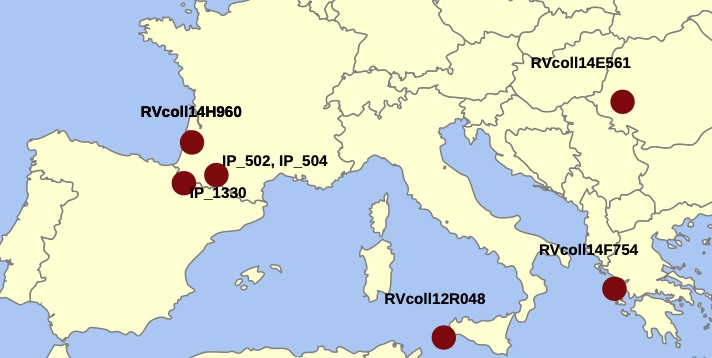

*...insert link to the BioArXiv preprint* 


## 1.2. Bioinformatics

### 1.2.1 Parsing data
- **parsing**: the process of analyzing a string of symbols by conforming to the rules of a formal grammar.
- In order to parse files in the different data formats we will use several python libraries.
    - [pysam](https://pysam.readthedocs.io/en/latest/): for FASTA and SAM/BAM files
    - [scikit-allel](https://scikit-allel.readthedocs.io/en/stable/): for VCF files
    - [pybedtools](https://daler.github.io/pybedtools/): for BED files

### 1.2.2 An aside on linear coordinate systems used in genomics:
- a genome is traditionally represented as one or more (haploid) consensus sequences which are stored in a text files (e.g. FASTA files).
- a coordinate system is needed to delimit start and end positions of features (e.g. genes, exons, variants, telomeres, stop-codons, etc) along the genome.
- in genomics, two different coordinate systems are used depending on the file format:

#### 1.2.2.1 <b>zero-based</b> indexing

- <b>numbers the spaces</b> between bases
- also called interval-based indexing
- used in BED files
- length of a feature $length = end - start$
- used in many programming languages: C, Perl, Python, Java, Ruby, JavaScript, etc.

<code>
          A T A T G G T T A C
         | | | | | | | | | | |
         0 1 2 3 4 5 6 7 8 9 10
             [-----)   [-)
              [2,5)   [7,8)
</code>

#### 1.2.2.2 <b>one-based</b> indexing

- <b>numbers the bases</b>
- also called character-based
- length of feature $length = (end + 1) - start$
- used in GFF3/GTF/VCF files
- used in many programming languages: FORTRAN, SASL, MATLAB, R, Mathematica, Smalltalk, etc.

<code>
         A T A T G G T T A C
         | | | | | | | | | |
         1 2 3 4 5 6 7 8 9 10
             [---]    [-]
             [3,5]   [8,8]
</code>

#### 1.2.2.3 Coordinate transformations between 0-based and 1-based systems

<code>
     <b>0-based to 1-based</b>                      <b>1-based to 0-based</b>

   0 1 2 3 4 5 6 7 8 9 10                   1 2 3 4 5 6 7 8 9 10
   | | | | | | | | | | |                    | | | | | | | | | |
    A T A T G G T T A C                     A T A T G G T T A C
    | | | | | | | | | |                    | | | | | | | | | | |
    1 2 3 4 5 6 7 8 9 10                   0 1 2 3 4 5 6 7 8 9 10
</code>
<code>
    <b>1_start = 0_start + 1</b>                  <b>0_start = 1_start - 1</b>
    1_end   = 0_end                        0_end   = 1_end
</code>

#### 1.2.2.4 Further reading
- https://tidyomics.com/blog/2018/12/09/2018-12-09-the-devil-0-and-1-coordinate-system-in-genomics/
- Casey M. Bergman (2012) A proposal for the reference-based annotation of de novo transposable element insertions, Mobile Genetic Elements, 2:1, 51-54, DOI: 10.4161/mge.19479                                    
- https://wiki.c2.com/?WhyNumberingShouldStartAtZero
- https://wiki.c2.com/?WhyNumberingShouldStartAtOne

# 2. Practical

Files needed are located in `qm:/data/lohse/modelgenomland/analyses/pga_course_2021/practical_4/data`:

  - `iphiclides_podalirius.v2_0.sequences.softmasked.fasta`
  - `iphiclides_podalirius.chromosomes.variants.iphiclides_podalirius.IP_504.chromosome_5.vcf.gz`
  - `iphiclides_podalirius.chromosomes.variants.iphiclides_podalirius.IP_504.chromosome_5.vcf.gz.tbi`
  - `iphiclides_podalirius.v2_0.callable.bed`
  - `iphiclides_podalirius.v2_0.chromosomes.braker.gt.exon.bed`
  - `iphiclides_podalirius.v2_0.chromosomes.braker.gt.3rd_codon_pos.bed`
  - `iphiclides_podalirius.v2_0.chromosomes.braker.gt.intron.bed`
  - `iphiclides_podalirius.v2_0.chromosomes.braker.gt.intergenic.bed`

For the practical these will be in a git folder. Ideally everybody would pick a different VCF.

## 2.1 Working with FASTA files

[FASTA](https://en.wikipedia.org/wiki/FASTA_format) files are used for storing sequence data – usually DNA, RNA, or protein sequences.

In this section you will:

1. parse the FASTA file of the *I. podalirius* genome assembly
2. visualise the distribution of sequence lengths
3. select the chromosome you will focus on for the rest of the practical

### 2.1.1 Parsing the FASTA file of the *I. podalirius* genome assembly
Let's start by creating a [`pysam.Fastafile`](https://pysam.readthedocs.io/en/latest/api.html#pysam.FastaFile) object from the *I. podalirius* genome assembly and store it in the variable `fasta`:

In [4]:
fasta = pysam.Fastafile("/Users/dlaetsch/git/population-genomic-analysis/data/iphiclides_podalirius.v2_0.sequences.softmasked.fasta")
print("Finished loading.")

Finished loading.


### 2.1.2 Visualising the distribution of sequence lengths

<div class="alert alert-block alert-warning">
    <b>Python recipe: pd dataframes</b>
    
    
We have so far dealt with python lists and arrays. When analyzing real data, we often want to store many pieces of information together. A [pandas](https://pandas.pydata.org/docs/reference/index.html) dataframe lets us do just that (if you've used `R` before, you will be familiar with dataframes)! Dataframes make further analysis and plotting with [seaborn](https://seaborn.pydata.org/api.html) much easier.
    
Let's use the <code>pysam.Fastafile</code> object stored in the variable <code>fasta</code> to get the names (<code>fasta.references</code>) and lengths (<code>fasta.lengths</code>) of the sequences contained in the FASTA file and use them to construct a dict from which the dataframe is build. This creates dataframe with two columns: <code>'chrom'</code> and <code>'lengths'</code>:
</div>

In [5]:
df = pd.DataFrame({'chrom': fasta.references, 'lengths': fasta.lengths})
print(df)

                                         chrom   lengths
0    iphiclides_podalirius.IP_504.chromosome_Z  21051824
1    iphiclides_podalirius.IP_504.chromosome_2  17990613
2    iphiclides_podalirius.IP_504.chromosome_3  17426007
3    iphiclides_podalirius.IP_504.chromosome_4  16757360
4    iphiclides_podalirius.IP_504.chromosome_5  15345845
..                                         ...       ...
255    iphiclides_podalirius.IP_504.contig_226      5021
256    iphiclides_podalirius.IP_504.contig_227      4857
257    iphiclides_podalirius.IP_504.contig_228      4599
258    iphiclides_podalirius.IP_504.contig_229      4132
259    iphiclides_podalirius.IP_504.contig_230      2926

[260 rows x 2 columns]


We can print the first and last 5 rows of the dataframe using `head()` and `tail()` 

In [6]:
print("head \n", df.head())

print("tail \n", df.tail())

head 
                                        chrom   lengths
0  iphiclides_podalirius.IP_504.chromosome_Z  21051824
1  iphiclides_podalirius.IP_504.chromosome_2  17990613
2  iphiclides_podalirius.IP_504.chromosome_3  17426007
3  iphiclides_podalirius.IP_504.chromosome_4  16757360
4  iphiclides_podalirius.IP_504.chromosome_5  15345845
tail 
                                        chrom  lengths
255  iphiclides_podalirius.IP_504.contig_226     5021
256  iphiclides_podalirius.IP_504.contig_227     4857
257  iphiclides_podalirius.IP_504.contig_228     4599
258  iphiclides_podalirius.IP_504.contig_229     4132
259  iphiclides_podalirius.IP_504.contig_230     2926


Individual columns can be selected using `[]` and the name of the column:

In [7]:
print("=> Lengths \n", df['lengths'].head())

=> Lengths 
 0    21051824
1    17990613
2    17426007
3    16757360
4    15345845
Name: lengths, dtype: int64


Pandas also allows running simple computations on the dataframe columns:

In [8]:
print("=> Total length of sequences in FASTA is: ", df['lengths'].sum())
print("=> Total number of sequences in FASTA is: ", df['lengths'].count())
print(f"=> The longest sequence is {df['lengths'].max()} b, the shortest is {df['lengths'].min()} b")

=> Total length of sequences in FASTA is:  430729501
=> Total number of sequences in FASTA is:  260
=> The longest sequence is 21051824 b, the shortest is 1000 b


The min and max suggest that there is a big range of sequence lengths contained in the fasta file. Let's plot this distribution!

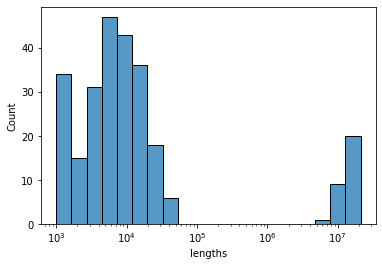

In [9]:
p = sns.histplot(data=df, x='lengths', log_scale=True)

- The reason why this distribution is bimodal is that the genome assembly contains both chromosomes AND contigs, i.e. contiguously assembled sequences which could not be scaffolded to chromosomes.
- Let's add a new column `'label'` to the dataframe to easily reflect this when plotting.

<div class="alert alert-block alert-warning">
    <b>Python recipe: conditional expressions</b> 
    
We will use the <a href="https://numpy.org/doc/stable/reference/generated/numpy.where.html"> <code>numpy.where()</code> </a> function to populate the new <code>'label'</code> column based on the conditional expression <code> < 1_000_000 </code>. If we execute this expression on its own, we get a boolean series composed of True/False values for each row of the dataframe:
    </div>

In [10]:
df['lengths'] < 1_000_000

0      False
1      False
2      False
3      False
4      False
       ...  
255     True
256     True
257     True
258     True
259     True
Name: lengths, Length: 260, dtype: bool

<div class="alert alert-block alert-warning">        
We will use the conditional expressions to populate the new column <code>'labels'</code> with strings using the numpy function <code>np.where(condition, x, y)</code>:
    </div>

In [11]:
df['label'] = np.where(df['lengths'] < 1_000_000, '< 1 Mb', '>= 1Mb')
print(df)

                                         chrom   lengths   label
0    iphiclides_podalirius.IP_504.chromosome_Z  21051824  >= 1Mb
1    iphiclides_podalirius.IP_504.chromosome_2  17990613  >= 1Mb
2    iphiclides_podalirius.IP_504.chromosome_3  17426007  >= 1Mb
3    iphiclides_podalirius.IP_504.chromosome_4  16757360  >= 1Mb
4    iphiclides_podalirius.IP_504.chromosome_5  15345845  >= 1Mb
..                                         ...       ...     ...
255    iphiclides_podalirius.IP_504.contig_226      5021  < 1 Mb
256    iphiclides_podalirius.IP_504.contig_227      4857  < 1 Mb
257    iphiclides_podalirius.IP_504.contig_228      4599  < 1 Mb
258    iphiclides_podalirius.IP_504.contig_229      4132  < 1 Mb
259    iphiclides_podalirius.IP_504.contig_230      2926  < 1 Mb

[260 rows x 3 columns]


<div class="alert alert-block alert-success">    
    <b>Exercise 1:</b>  
Colour the histogram of sequence length we've plotted above using the newly generated column.
    
**Hint:** Check out the <a href="https://seaborn.pydata.org/tutorial/distributions.html"> <code>sns.displot()</code> </a> documentation.
    </div>

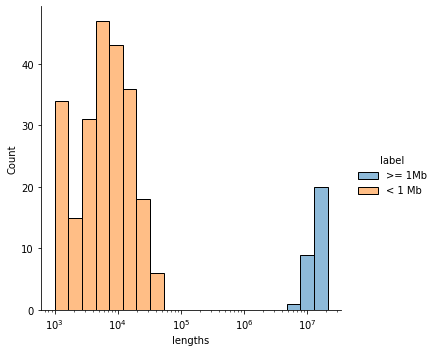

In [12]:
# SOL
p = sns.displot(data=df, x='lengths', log_scale=True, hue='label')

<div class="alert alert-block alert-success">    
    <b>Exercise 2:</b>
<ul>
<li>    
Subset <code>df</code> so that it only contains chromosomes and store this new dataframe in the variable <code>chrom_df</code>.</li>
<li>Calculate the total length and number of chromosomes.</li>
<li>How many chromsomes does <i>I. podalirius</i> have?</li>
<li>What is the total length of chromosome scaffolds?</li>
    </ul
        </div>

In [13]:
# SOL
chrom_df = df[df['label']=='>= 1Mb']
print(chrom_df['lengths'].count())
genome_len = chrom_df['lengths'].sum()
print(genome_len)

30
428609063


### 2.1.3 Selecting the chromosomes you will focus on for the rest of the practical
- this should be one of chromosomes 1-11

In [14]:
df[df['lengths'] > 1_000_000]

,chrom,lengths,label
0,iphiclides_podalirius.IP_504.chromosome_Z,21051824,>= 1Mb
1,iphiclides_podalirius.IP_504.chromosome_2,17990613,>= 1Mb
2,iphiclides_podalirius.IP_504.chromosome_3,17426007,>= 1Mb
3,iphiclides_podalirius.IP_504.chromosome_4,16757360,>= 1Mb
4,iphiclides_podalirius.IP_504.chromosome_5,15345845,>= 1Mb
5,iphiclides_podalirius.IP_504.chromosome_6,18577136,>= 1Mb
6,iphiclides_podalirius.IP_504.chromosome_7,15090856,>= 1Mb
7,iphiclides_podalirius.IP_504.chromosome_8,16356932,>= 1Mb
8,iphiclides_podalirius.IP_504.chromosome_9,17201248,>= 1Mb
9,iphiclides_podalirius.IP_504.chromosome_10,17339824,>= 1Mb


<div class="alert alert-block alert-success">    
    <b>Exercise 3:</b> Assign two variables <code>chrom_name</code> and <code>chrom_length</code> for your chromosome. Don't forget to add your name to the google doc. 
    </div>

In [15]:
#SOL
chrom_name = "iphiclides_podalirius.IP_504.chromosome_5"
chrom_length = 15345845

## 2.2 Working with VCF files

- [VCF](https://en.wikipedia.org/wiki/VCF_format) files are used for storing information about genomic variation 
  - along one (or more) linear reference sequences and
  - for one or more samples for which genotypes were called.
- A detailed description of the file format is available [here](https://samtools.github.io/hts-specs/VCFv4.2.pdf).
- In brief, VCF files are composed of 
  - a header section (indicated by "#" at the beginning of the line) explaining the data types listed in each row
  - rows containing information in columns (see following table) about the genetic variation across samples for a given position in the genome

| Column | Fieldname |                                     Description                                     |
|--------|-----------|-------------------------------------------------------------------------------------|
| 1      | CHROM     | Chromosome name                                                                     |
| 2      | POS       | 1-based position. For an indel, this is the position preceding the indel.           |
| 3      | ID        | Variant identifier. Usually the dbSNP rsID.                                         |
| 4      | REF       | Reference sequence at POS involved in the variant. For a SNP, it is a single base.  |
| 5      | ALT       | Comma delimited list of alternative seuqence(s).                                    |
| 6      | QUAL      | Phred-scaled probability of all samples being homozygous reference.                 |
| 7      | FILTER    | Semicolon delimited list of filters that the variant fails to pass.                 |
| 8      | INFO      | Semicolon delimited list of variant information.                                    |
| 9      | FORMAT    | Colon delimited list of the format of individual genotypes in the following fields. |
| 10+    | Sample(s) | Individual genotype information defined by FORMAT.                                  |

- **VCF files** are generated by providing BAM files (one for each sample, composed of reads of that sample mapped to the genome) to a variant caller. To map reads of resequenced individuals to the *I. podalirius* reference, we have used [freebayes](https://github.com/freebayes/freebayes)
- The **VCF files** you will be working on have been processed using [bcftools](https://samtools.github.io/bcftools/bcftools.html), and a variant was kept if:
  - it was not too bad bad (`QUAL>1`)
  - supported by reads on both strands (`SAF > 0 & SAR > 0`) 
    - `SAF`: Number of alternate observations on the forward strand
    - `SAR`: Number of alternate observations on the reverse strand
  - supported by both ends of reads (`RPR > 0 & RPL > 0`)
    - `RPL`: Reads Placed Left: number of reads supporting the alternate balanced to the left (5') of the alternate allele
    - `RPR`: Reads Placed Right: number of reads supporting the alternate balanced to the right (3') of the alternate allele
- An additional **callable-regions BED file** was created from the BAM files using [mosdepth](https://github.com/brentp/mosdepth). 
  - This BED file list the regions of the genome which have been covered to a certain depth $d \in [8, 2*mean]$) by each dataset. 
  - This file will be relevant when working with BED files 
 
> In this section you will:
> 1. Parse the VCF file of one of the *I. podalirius* chromosomes
> 2. Categorize variants based on 
>     - FILTER column 
>     - variant type (SNP vs. nonSNP) and 
>     - number of alleles (biallelic, triallelic, etc)
> 3. Create a mask array which includes only biallelic SNPs that passed the filters. These will be the variants we will use for subsequent analysis.
> 4. Categorize variants based on genotypes (HOMREF, HOMALT, HET, MISS) by sample

### 2.2.1 Parsing a VCF file using scikit-allel

Let us define the fields we want to parse from the VCF file:

In [37]:
query_fields = ['samples', 'calldata/GT', 'variants/CHROM', 'variants/POS', 'variants/NUMALT', 'variants/is_snp']

The function `allel.read_vcf()` will load the entire VCF file into a python dict of arrays/lists:

<div class="alert alert-block alert-success">    
    <b>Exercise 4:</b> 
        Change the code below to match the vcf file for your chromosome and read in the file.
    </div>

In [38]:
#SOL (leave)
vcf_f = "/Users/dlaetsch/git/population-genomic-analysis/data/iphiclides_podalirius.IP_504.chromosome_5.vcf.gz"

In [39]:
# this will take a few seconds to read the file, be patient ...
vcf_dict = allel.read_vcf(vcf_f, fields=query_fields)

Using the `keys()` method of the dict, we can check that the keys of `vcf_dict` are `query_fields` we have specified:

In [40]:
vcf_dict.keys()

dict_keys(['samples', 'calldata/GT', 'variants/CHROM', 'variants/NUMALT', 'variants/POS', 'variants/is_snp'])

Data can be explored using the keys:

In [41]:
print("[+] samples ", vcf_dict['samples'])
print("[+] genotypes (shape, dtype) ", vcf_dict['calldata/GT'].shape, vcf_dict['calldata/GT'].dtype)
print("[+] CHROM (shape, dtype) ", vcf_dict['variants/CHROM'].shape, vcf_dict['variants/CHROM'].dtype)
print("[+] POS (shape, dtype) ", vcf_dict['variants/POS'].shape, vcf_dict['variants/POS'].dtype)
print("[+] NUMALT (shape, dtype) ", vcf_dict['variants/NUMALT'].shape, vcf_dict['variants/NUMALT'].dtype)
print("[+] is_snp (shape, dtype) ", vcf_dict['variants/is_snp'].shape, vcf_dict['variants/is_snp'].dtype)

[+] samples  ['IP_RVcoll14H960' 'IP_RVcoll14F754' 'IP_502' 'IP_1330' 'IP_RVcoll12R048'
 'IP_504.10X' 'IP_RVcoll14E561']
[+] genotypes (shape, dtype)  (650752, 7, 2) int8
[+] CHROM (shape, dtype)  (650752,) object
[+] POS (shape, dtype)  (650752,) int32
[+] NUMALT (shape, dtype)  (650752,) int32
[+] is_snp (shape, dtype)  (650752,) bool


### 2.2.2 Categorize variants 

Let's look at the boolean array of `is_snp` by constructing the following dict:

In [42]:
is_SNP_array = vcf_dict['variants/is_snp']
is_SNP_df = pd.DataFrame({'is_snp': is_SNP_array})
print('[+] These are the first five rows of the dataframe: \n%s' % is_SNP_df.head())

[+] These are the first five rows of the dataframe: 
   is_snp
0   False
1    True
2    True
3    True
4    True


<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> Pandas dataframes allow counting values in a column using the <a href="https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html"><code>.value_counts()</code></a> method.
    </div>

In [43]:
print('[+] The value counts of column "is_SNP" in the dataframe are the following: \n%s' % is_SNP_df['is_snp'].value_counts())

[+] The value counts of column "is_SNP" in the dataframe are the following: 
True     546796
False    103956
Name: is_snp, dtype: int64


<AxesSubplot:xlabel='is_snp', ylabel='count'>

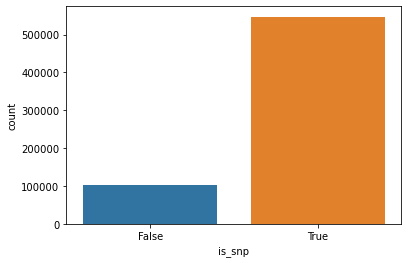

In [44]:
# let's plot those counts
sns.countplot(data=is_SNP_df, x='is_snp')

<div class="alert alert-block alert-success">    
    <b>Exercise 5:</b>
  
Count the values in the numeric array <code>vcf_dict['variants/NUMALT']</code> which indicates how many alternate alleles were called at a given position.
<ul>
<li> How many biallelic, triallelic, and tetrallelic variants are there?</li>
<li> Is it reasonable to ignore multiallelic sites in this dataset?</li>    
<li> <b>Bonus</b>: Why are there so many alleles?</li>
<li> <b>Hint 1</b>: SNPs only can have 3 alternate alleles </li>
<li> <b>Hint 2</b>: in a barplot y-axis can be set to log-scale with by saving the plot in a variable and calling the <code>set_yscale('log')</code> method: i.e. use 
    <code>p = sns.countplot(data=..., x=..., hue=...)</code>
    and 
    <code>p.set_yscale("log")</code>
    </li>
           </ul>

In [45]:
#SOL
numalt_array = vcf_dict['variants/NUMALT']
numalt_df = pd.DataFrame({'numalt': numalt_array})
print('[+] Tally of number of alternate alleles: \n%s' %numalt_df['numalt'].value_counts())

[+] Tally of number of alternate alleles: 
1     608622
2      30816
3       7035
4       2468
5       1010
6        475
7        204
8         76
9         24
10        18
11         3
12         1
Name: numalt, dtype: int64


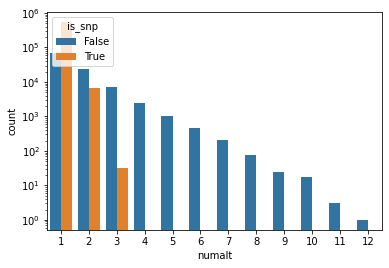

In [46]:
#SOL
# nonSNP variants can have many more alleles
numalt_df['is_snp'] = is_SNP_df['is_snp']
p = sns.countplot(data=numalt_df, x='numalt', hue='is_snp')
p.set_yscale("log")

### 2.2.3 Creating a mask array for biallelic SNPs

We often want to filter variants before analysing them. Since no simple mutation models exist for indels and complex variants, population genomic analyses are generally restricted to SNPs. For the same reason, analyses of WGS data are also often limited to biallelic SNPs which can be interpreted assuming the infinite sites mutation model (see mini lecture 1 & 2).

How do we filter vcf files? We can construct a boolean `mask_array` by chaining several logical expressions together with the `&` operator. Let's define define a mask for biallelic SNPs:

In [47]:
numalt_array = vcf_dict['variants/NUMALT']
is_SNP_array = vcf_dict['variants/is_snp']

- `is_SNP_array` is a boolean array of which we want only those values which are `True`
- `numalt_array` is an integer array of which we want only those values which are `1` (i.e. the variant is bi-allelic)

In [48]:
mask_array = (numalt_array == 1) & (is_SNP_array == True)
print(mask_array)

[False  True  True ...  True  True  True]


This boolean `mask_array` can be used to index (and thus subset) other arrays, e.g. the genotype array `gt_array` and the `pos_array`

In [49]:
snp_gts = vcf_dict['calldata/GT'][mask_array]
snp_pos = vcf_dict['variants/POS'][mask_array]

<div class="alert alert-block alert-danger">        
From here onwards we will only use the biallelic SNP genotypes (<code>snp_gts</code>) and their positions (<code>snp_pos</code>).
    </div>

### 2.2.4 Categorize variants by genotype and sample
- Scikit-allel's `GenotypeArray` class is a convenient way of interacting with genotype data.
- Full description of its methods can be found [here](https://scikit-allel.readthedocs.io/en/stable/model/ndarray.html#genotypes)
- Genotypes are represented as a 3-dimensional numpy array of integers. By convention, 
    - the first dimension corresponds to the variants genotyped, 
    - the second dimension corresponds to the samples genotyped, and 
    - the third dimension corresponds to the ploidy of the samples.
- Each integer within the array corresponds to an allele index, where 
    - `0` is the reference allele, 
    - `1` is the first alternate allele, 
    - `2` is the second alternate allele, 
    - ... 
    - `-1` (or any other negative integer) is a missing allele call. 

In [50]:
print('[+] Genotype data is parsed as numpy arrays by scikit-allel: \n%s with shape %s' % (type(snp_gts), snp_gts.shape))
print('[+] The first variant has the following genotype data in the VCF file: \n%s' % snp_gts[0])

[+] Genotype data is parsed as numpy arrays by scikit-allel: 
<class 'numpy.ndarray'> with shape (539954, 7, 2)
[+] The first variant has the following genotype data in the VCF file: 
[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]]


<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> We can use the class   
    <a href="https://scikit-allel.readthedocs.io/en/stable/model/ndarray.html#allel.GenotypeArray"><code>allel.GenotypeArray</code></a> of scikit-allel to interact more easily with genotype data. This class also has access to all methods available for <a href="https://scikit-allel.readthedocs.io/en/stable/model/ndarray.html#genotypes"><code>allel.Genotypes</code></a>.
    </div>

Typing the variable name gives the `shape` and prints the head and tail of the array:

In [51]:
snp_ga = allel.GenotypeArray(snp_gts);
snp_ga

<GenotypeArray shape=(539954, 7, 2) dtype=int8>
0/0 0/0 0/0 0/0 1/1 0/0 0/0
1/1 0/1 ./. 0/0 0/0 0/0 1/1
./. 1/1 1/1 0/0 0/0 0/0 ./.
...
0/0 0/0 0/0 0/0 0/1 0/0 0/0
0/1 0/0 0/0 ./. 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 0/0 0/1

The genotype array class has a whole bunch of useful methods; many of which are fairly self-explanatory: 

In [52]:
print(dir(snp_ga))

['__abs__', '__add__', '__and__', '__array__', '__class__', '__delattr__', '__dict__', '__dir__', '__div__', '__doc__', '__eq__', '__floordiv__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__inv__', '__invert__', '__iter__', '__le__', '__len__', '__lshift__', '__lt__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow__', '__reduce__', '__reduce_ex__', '__repr__', '__rshift__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__weakref__', '__xor__', '_is_phased', '_mask', '_repr_html_', '_values', 'caption', 'compress', 'concatenate', 'copy', 'count_alleles', 'count_alleles_subpops', 'count_call', 'count_called', 'count_het', 'count_hom', 'count_hom_alt', 'count_hom_ref', 'count_missing', 'display', 'displayall', 'fill_masked', 'from_packed', 'from_sparse', 'get_display_items', 'haploidify_samples', 'i

<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> We can use the functions 
    
- <a href="https://scikit-allel.readthedocs.io/en/stable/model/ndarray.html#allel.Genotypes.count_missing"><code>allel.Genotypes.count_missing()</code></a>,
- <a href="https://scikit-allel.readthedocs.io/en/stable/model/ndarray.html#allel.Genotypes.count_hom_ref"><code>allel.Genotypes.count_hom_ref()</code></a>,
- <a href="https://scikit-allel.readthedocs.io/en/stable/model/ndarray.html#allel.Genotypes.count_hom_alt"><code>allel.Genotypes.count_hom_alt()</code></a>, and
- <a href="https://scikit-allel.readthedocs.io/en/stable/model/ndarray.html#allel.Genotypes.count_het"><code>allel.Genotypes.count_het()</code></a> 

to count those four possible genotypes for each sample. 
    </div>

In [53]:
count_missing = snp_ga.count_missing(axis=0)
count_hom_ref = snp_ga.count_hom_ref(axis=0)
count_hom_alt = snp_ga.count_hom_alt(axis=0)
count_het = snp_ga.count_het(axis=0)

Let's turn these arrays of counts into columns of a dataframe:

In [54]:
samples = vcf_dict['samples']
print("[+] samples ", vcf_dict['samples'])
df = pd.DataFrame({'sample': samples, 'MISS': count_missing, 'HOMREF': count_hom_ref, 'HOMALT': count_hom_alt, 'HET': count_het})
df

[+] samples  ['IP_RVcoll14H960' 'IP_RVcoll14F754' 'IP_502' 'IP_1330' 'IP_RVcoll12R048'
 'IP_504.10X' 'IP_RVcoll14E561']


,sample,MISS,HOMREF,HOMALT,HET
0,IP_RVcoll14H960,2286,395855,44273,97540
1,IP_RVcoll14F754,2507,385604,60453,91390
2,IP_502,2075,405837,41623,90419
3,IP_1330,6271,203691,90480,239512
4,IP_RVcoll12R048,4281,428711,57904,49058
5,IP_504.10X,17,456263,98,83576
6,IP_RVcoll14E561,2384,387195,57351,93024


<div class="alert alert-block alert-success">
    <b>Exercise 6:</b> Use these counts to compute the per base heterozygosity for each sample. How does the mean heterozygosity across samples compare to estimates of genetic diversity for <i>D. menalogaster </i> (from practical 2) and other insects <a href="https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1001388"> (see Figure 1 in Leffler et al)</a>
    </div

In [55]:
#SOL
heterozygosity = snp_ga.count_het(axis=0) / chrom_length
print("Mean heteropzygosity for the filtered I. podalirius data is", heterozygosity.mean()) 

Mean heteropzygosity for the filtered I. podalirius data is 0.006930856993724174


We can now also take a look into where the different genotypes are located on the chromsome, as opposed to just counting them. 

For this we can use the `plot_int_array_by_samples()` function we have used previously in P3.

In [56]:
import matplotlib as mpl
def plot_int_array_by_samples(array, labels, samples, title=None):
    # set figure height depending on number of samples
    fig, ax = plt.subplots(figsize=(20, .4 * array.shape[1]))
    # create colour palette
    palette = sns.color_palette('colorblind')
    # subset palette based on unique values in array
    cmap = mpl.colors.ListedColormap([palette[i] for i in range(len(labels))])
    # plot
    ax.pcolormesh(array.T, cmap=cmap, vmin=np.min(array), vmax=np.max(array))
    # tidy up axes
    ax.set_yticks(np.arange(array.shape[1]) + .5)
    ax.set_yticklabels(samples)
    ax.set_ylabel('Samples')
    ax.set_xlabel('Variant')
    # make legend based on labels (MUST BE IN CORRECT ORDER!)
    patches = [mpl.patches.Patch(color=cmap(i)) for i in range(len(labels))]
    box_pos = ax.get_position()
    plt.legend(patches, labels, bbox_to_anchor=(1.1, 0.5))
    if title:
        ax.set_title(title)

But we first need to create the input for `plot_int_array_by_samples()`:
- `array` should contain a digit for each of the four genotypes, i.e.: 0 (=HOMREF), 1 (=HET), 2 (=HOMALT), 3 (=MISSING)
- `labels` should contain the labels we want to see in the legend `['HOMREF', 'HET', 'HOMALT', 'MISSING']`
- `samples` should contain the sample names


For all these data, the order matters.

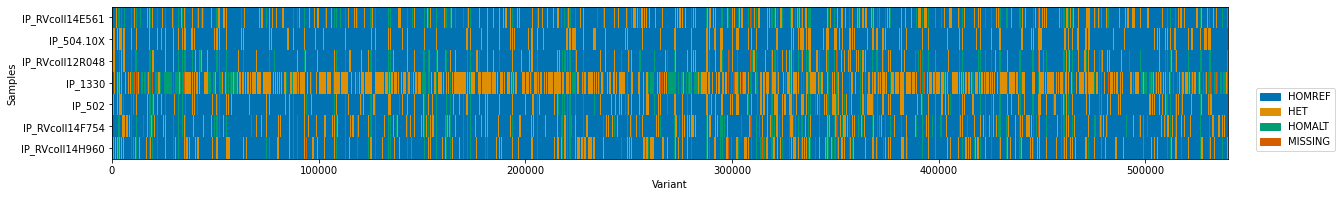

In [59]:
array = np.zeros((snp_gts.shape[0], snp_gts.shape[1]))
array = np.where(allel.GenotypeArray(snp_gts).is_hom_ref(), 0, 
                              np.where(allel.GenotypeArray(snp_gts).is_het(), 1,
                                    np.where(allel.GenotypeArray(snp_gts).is_hom_alt(), 2, 3)))
labels = ['HOMREF', 'HET', 'HOMALT', 'MISSING']
samples = vcf_dict['samples']
plot_int_array_by_samples(array, labels, samples)

<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> In order to easily plot the table, we are going to turn the dataframe into a <a href="https://en.wikipedia.org/wiki/Pivot_table">Pivot table</a> using <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot_table.html#pandas.DataFrame.pivot_table"><code>pandas.DataFrame.pivot_table</code></a>. This will index the dataframe by the sample column and allow plotting functions to access values based on sample name.
    </div>

In [60]:
pivot_table = pd.pivot_table(df, index='sample', aggfunc=np.sum)
pivot_table

,HET,HOMALT,HOMREF,MISS
sample,,,,
IP_1330,239512,90480,203691,6271
IP_502,90419,41623,405837,2075
IP_504.10X,83576,98,456263,17
IP_RVcoll12R048,49058,57904,428711,4281
IP_RVcoll14E561,93024,57351,387195,2384
IP_RVcoll14F754,91390,60453,385604,2507
IP_RVcoll14H960,97540,44273,395855,2286


<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> All Pandas DataFrames support plotting via <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html#pandas-dataframe-plot"><code>pandas.DataFrame.plot()</code></a>. 
    </div>

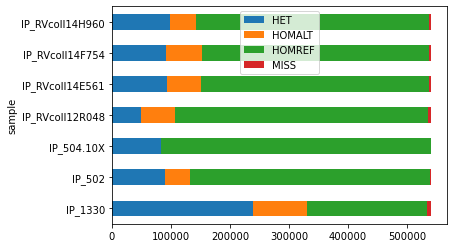

In [61]:
pivot_table.plot(kind='barh', stacked=True)
plt.show()

 Another useful plot is <a href="https://seaborn.pydata.org/generated/seaborn.barplot.html"><code>seaborn.barplot()</code></a>. This plots the heterozygosity of each sample:

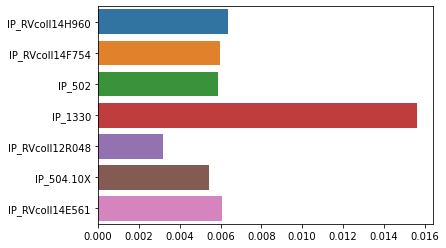

In [62]:
sns.barplot(x=heterozygosity, y=samples)
plt.show()

<div class="alert alert-block alert-success">
    <b>Exercise 7:</b> Look at the two plots above. Is there a clear outlier in heterozygosity? Given the map of sample locations what could explain this outlier? Does any sample stand out in terms of HOMALT? Adapt the code cell below to remove the outlier sample from the dataset. This will overwrite the variable <code>snp_ga</code>. 
    
How is the mean heterozygosity affected?
    
Redo the barplot to make sure you get the same plot as before, with the exception of the removed outlier sample.
    </div>

Mean heteropzygosity for the filtered I. podalirius data is 0.005484731100394494


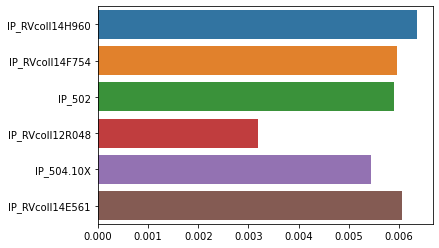

In [63]:
# SOL (keep)
# subset samples
samples = ['IP_RVcoll14H960', 'IP_RVcoll14F754', 'IP_502', 'IP_1330', 'IP_RVcoll12R048', 'IP_504.10X', 'IP_RVcoll14E561']
samples_new = [sample for sample in samples if sample != 'IP_1330']
# load vcf again
vcf_dict_new = allel.read_vcf(vcf_f, fields=query_fields, samples=samples_new)
# create the genotype array of biallelic SNPs (using the mask_array)
snp_ga_new = allel.GenotypeArray(vcf_dict_new['calldata/GT'])[mask_array]
# estimate heterozygosity
heterozygosity_new = snp_ga_new.count_het(axis=0) / chrom_length
# mean heterozygosity (remove)
print("Mean heteropzygosity for the filtered I. podalirius data is", heterozygosity_new.mean())
# plot heterozygosity (remove)
sns.barplot(x=heterozygosity_new, y=samples_new)
plt.show()

In [64]:
# CAUTION: Only once you are happy with the removal of the outlier sample, execute this cell!
snp_ga = snp_ga_new
samples = samples_new

### 2.2.5 Visualising measures of diversity along the chromosome

<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> We can convert the   
    <a href="https://scikit-allel.readthedocs.io/en/stable/model/ndarray.html#allel.GenotypeArray"><code>allel.GenotypeArray</code></a> into an <a href="https://scikit-allel.readthedocs.io/en/stable/model/ndarray.html#allelecountsarray"><code>allel.AllelCountsArray</code></a> using the method
    <a href="https://scikit-allel.readthedocs.io/en/stable/model/ndarray.html#allel.GenotypeArray.count_alleles"><code>allel.GenotypeArray.count_alleles()</code></a>. Allele counts can be used to compute many <a href="https://scikit-allel.readthedocs.io/en/stable/stats.html#">population genetic estimators</a> using scikit-allel methods.
    </div>

In [65]:
snp_ac = snp_ga.count_alleles()
print(snp_ac)

10  2
 5  5
 4  4
...
11  1
11  1
11  1



<div class="alert alert-block alert-success">
    <b>Exercise 8:</b> Use the <code>allel</code> function <a href='https://scikit-allel.readthedocs.io/en/stable/stats/diversity.html'> <code>sequence diversity</code></a> to estimate pairwise genetic diversity (Nei's $\pi$) in <i>I. podalirius</i>. 
    
<b>Hint</b>: The method requires several inputs, such as: 
  - the position of each variant <code>snp_pos</code>
  - the allele counts for each variant <code>snp_ac</code> and
  - the position of the first <code>start</code> and last <code>stop</code> base of the sequence so it can estimate the number of invariant/monomorphic sites (i.e. all sites that are not variant)
    </div>

In [66]:
# SOL
allel.sequence_diversity(snp_pos, snp_ac, start=1, stop=chrom_length)

0.006330159934145248

<div class="alert alert-block alert-success">
    <b>Exercise 9:</b> What could explain the fact that the estimate of pairwise diversity is higher than the average heterozygosity you've estimated in the previous section?
    </div>

In [67]:
#SOL
#in a W-F population we expect individual heterozygosity (i.e. measuring pairwise genetic diveristy in one individual) and pairwise genetic diversity averaged across all samples to be the same. 
#Population structure, isolation by distance and/or inbreeding will generate positive $F_{IS}$.

<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> A more granular view of how genetic diversity varies along the chromosome can be gained through the     
    <a href="https://scikit-allel.readthedocs.io/en/stable/stats/diversity.html#allel.windowed_diversity"><code>allel.windowed_diversity()</code></a> method.
</div>

For example, diversity measured in 100kb windows varies over a factor of three:

The maximum diversity is 0.011215104617604619
The SD of pi is 0.0013751007712255905


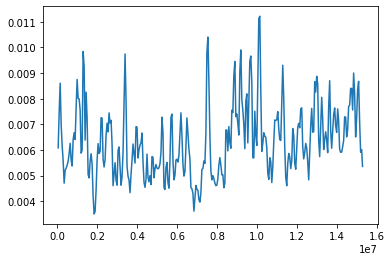

In [68]:
# plotting along the genome
window_size = 100_000
pi, windows, bases, counts = allel.windowed_diversity(snp_pos, snp_ac, size=window_size, start=0, stop=chrom_length, step=int(window_size/2))
x = windows[:,1] - (window_size / 2)
print("The maximum diversity is", max(pi))
print("The SD of pi is", np.std(pi))
sns.lineplot(x=x, y=pi)
plt.show()

<div class="alert alert-block alert-success">
    <b>Exercise 10:</b> Explore how the heterogeneity in genetic diversity depends on the window size.
    </div>

The maximum diversity is 0.013388404040404039
The SD of pi is 0.0016068595162311544


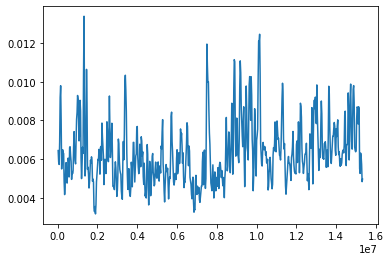

In [69]:
# plotting along the genome
window_size = 50_000
pi, windows, bases, counts = allel.windowed_diversity(snp_pos, snp_ac, size=window_size, start=0, stop=chrom_length, step=int(window_size/2))
x = windows[:,1] - (window_size / 2)
sns.lineplot(x=x, y=pi)
print("The maximum diversity is", max(pi))
print("The SD of pi is", np.std(pi))
plt.show()

---

## 2.3.0 Working with BED files
- The *I. podalirius* genome has been annotated using the gene prediction software [BRAKER](https://github.com/Gaius-Augustus/BRAKER) and mapping data of RNAseq reads against the genome. 
- This yielded an "annotation" describing the position of each gene, mRNA, exon, intron, and start/stop-codon.
- We have prepared the following annotation BED files for you to work on:

|          feature type          |                               filename                               |
|--------------------------------|----------------------------------------------------------------------|
| exons                          | `iphiclides_podalirius.v2_0.chromosomes.braker.gt.exon.bed`          |
| third-codon-positions of exons | `iphiclides_podalirius.v2_0.chromosomes.braker.gt.3rd_codon_pos.bed` |
| introns                        | `iphiclides_podalirius.v2_0.chromosomes.braker.gt.intron.bed`        |
| intergenic                     | `iphiclides_podalirius.v2_0.chromosomes.braker.gt.intergenic.bed`    |
| **callable-regions BED file**  | `iphiclides_podalirius.callable.bed`                                 |

- The **callable-regions BED file** contains regions of the genome where all samples displayed sufficient, but not excessive, sequencing depth. 
  - This means that for every base in **callable-regions BED file** we can be sure that it is either:
    - accurately described as **variant if present in the VCF** or
    - accurately described as **invariant if not present in the VCF**



- One troublesome part in Bioinformatics is that BED files have a different coordinate system than GFF/GTF/VCF files.
  - BED files are 0-based (the first base of the chromosome is considered position 0) and the feature does not include the stop position.
  - VCF, GFF, and GTF files are 1-based (the first base of the chromosome is considered position 1) and the feature includes the stop position.


  
- The python library [pybedtools](https://daler.github.io/pybedtools/) is a convenient way of interacting with annotation files (BED/GFF/GTF/VCF)
  - It takes care of the complicated steps involving coordinate-system-operations
  - For bigger datasets it is often easier to use the underlying [BedTools](https://bedtools.readthedocs.io/en/latest/) program directly in the commandline.



> In this section you will focus on the following genomic regions described in BED files:
> - **exons**: all genomic positions located within exons of genes
> - **third_codon_positions**: all genomic positions located within the third codon positions of exons of genes
> - **introns**: all genomic positions located within introns of genes
> - **intergenic**: all genomic positions that are not part of genes
> 
> For each of these genomic regions you will:
> 1. parse the BED file describing the genomic regions
> 2. Intersect the intervals with the **callable-regions BED file** which delimits those regions that obtained sufficient sequencing depth in all samples (i.e. a depth filter), this will yield:
>    - **exons_callable**
>    - **third_codon_positions_callable**
>    - **introns_callable**
>    - **intergenic_callable**
> 3. Subset the variants to only those contained within each genomic region
> 4. Quantify variation within each of these four types of genomic regions 

### 2.3.1 Parsing BED files

Let's first define variables for each of the paths to the BED files

In [82]:
exon_f = '/Users/dlaetsch/git/population-genomic-analysis/data/iphiclides_podalirius.v2_0.chromosomes.braker.gt.exon.bed'
tcp_f = '/Users/dlaetsch/git/population-genomic-analysis/data/iphiclides_podalirius.v2_0.chromosomes.braker.gt.tcp.bed'
intron_f = '/Users/dlaetsch/git/population-genomic-analysis/data/iphiclides_podalirius.v2_0.chromosomes.braker.gt.intron.bed'
intergenic_f = '/Users/dlaetsch/git/population-genomic-analysis/data/iphiclides_podalirius.v2_0.chromosomes.braker.gt.intergenic.bed'
callable_f = '/Users/dlaetsch/git/population-genomic-analysis/data/iphiclides_podalirius.v2_0.chromosomes.callable.bed'

Let's load the different BED files of regions of interest:

In [83]:
exon_intervals = pybedtools.BedTool(exon_f)
tcp_intervals = pybedtools.BedTool(tcp_f)
intron_intervals = pybedtools.BedTool(intron_f)
intergenic_intervals = pybedtools.BedTool(intergenic_f)
callable_intervals = pybedtools.BedTool(callable_f)

Let's take a look at the exons ...

In [84]:
exon_intervals.head()

iphiclides_podalirius.IP_504.chromosome_10	54	420	g11622.t1.exon1	.	+
 iphiclides_podalirius.IP_504.chromosome_10	1860	2047	g11623.t1.exon1	.	+
 iphiclides_podalirius.IP_504.chromosome_10	4885	5490	g11623.t1.exon2	.	+
 iphiclides_podalirius.IP_504.chromosome_10	5584	5643	g11623.t1.exon3	.	+
 iphiclides_podalirius.IP_504.chromosome_10	5800	5910	g11623.t1.exon4	.	+
 iphiclides_podalirius.IP_504.chromosome_10	6378	6407	g11623.t1.exon5	.	+
 iphiclides_podalirius.IP_504.chromosome_10	19018	19123	g11624.t1.exon1	.	+
 iphiclides_podalirius.IP_504.chromosome_10	21194	21249	g11624.t1.exon2	.	+
 iphiclides_podalirius.IP_504.chromosome_10	21330	21433	g11624.t1.exon3	.	+
 iphiclides_podalirius.IP_504.chromosome_10	21768	22023	g11624.t1.exon4	.	+
 

In [85]:
example_interval = exon_intervals[0]
print("chrom  : ", example_interval.chrom)
print("start  : ", example_interval.start)
print("end    : ", example_interval.end)
print("name   : ", example_interval.name)
print("Fields : ", example_interval.fields)

chrom  :  iphiclides_podalirius.IP_504.chromosome_10
start  :  54
end    :  420
name   :  g11622.t1.exon1
Fields :  ['iphiclides_podalirius.IP_504.chromosome_10', '54', '420', 'g11622.t1.exon1', '.', '+']


### 2.3.2 Intersecting annotation intervals with callable-regions BED file
Let's start by defining a function which will help us to sum up the lengths of intervals in pybedtools objects

In [86]:
def get_bed_length(bed_intervals):
    return sum([(bed_interval.end - bed_interval.start) for bed_interval in bed_intervals])

<div class="alert alert-block alert-success">
    <b>Exercise 11:</b> Use <code>get_bed_length</code> to compute the total length of callable sites. How does this compare to the total length of the reference genome you computed in exercise 2?
    </div>

In [87]:
#SOL
call_len = get_bed_length(callable_intervals);
print('The total length of callable sequence is', call_len)
print('The fraction of callable sequence is', call_len/genome_len)

The total length of callable sequence is 421011383
The fraction of callable sequence is 0.9822736366169653


<div class="alert alert-block alert-warning">
    <b>Python recipe: Intersecting bed intervals </b>
    
We often need to find the genomic intervals of sequence meeting several filters or features we have defined as bed files. For example, we might be interested in all exons that are callable. Let's use <code>.intersect()</code> to find these <b>for the focal chromosome only</b> and assign them to a new variable <code>exons_callable</code>:
</div>

We first use `.intersect()` to extract the `callable_intervals` for the focal chromosome only:

In [88]:
focal_chrom = pybedtools.bedtool.BedTool([[chrom_name, 0, chrom_length]], from_string=False)
callable_intervals = callable_intervals.intersect(focal_chrom)

In [89]:
exons_callable = exon_intervals.intersect(callable_intervals)
print('The total length of callable exon sequence on', chrom_name, 'is',  get_bed_length(exons_callable))
print('This is',  get_bed_length(exons_callable)/get_bed_length(exon_intervals.intersect(focal_chrom)), 'of exonic sequence') 

The total length of callable exon sequence on iphiclides_podalirius.IP_504.chromosome_5 is 636108
This is 0.9924239114833282 of exonic sequence


<div class="alert alert-block alert-success">
    <b>Exercise 12:</b> Generate analogous intervals for the callable intronic <code>intron_callable</code>, intergenic sequence <code>intergenic_callable</code> and third codon positions <code>tcp_callable</code>. How does the fraction of callable sequence for these partitions compare to that of exons?
    </div>

In [90]:
#SOL
intron_callable = intron_intervals.intersect(callable_intervals)
print('The total length of callable intron sequence is',  get_bed_length(intron_callable))
print('This is',  get_bed_length(intron_callable)/get_bed_length(intron_intervals.intersect(focal_chrom)), 'of intronic sequence') 

The total length of callable intron sequence is 4128800
This is 0.9855972653065609 of intronic sequence


In [91]:
#SOL
intergenic_callable = intergenic_intervals.intersect(callable_intervals)
print('The total length of callable intergenic sequence is',  get_bed_length(intergenic_callable))
print('This is',  get_bed_length(intergenic_callable)/get_bed_length(intergenic_intervals.intersect(focal_chrom)), 'of intronic sequence') 

The total length of callable intergenic sequence is 10149560
This is 0.9802080178504101 of intronic sequence


In [92]:
#SOL
tcp_callable = tcp_intervals.intersect(callable_intervals)
print('The total length of callable intergenic sequence is',  get_bed_length(tcp_callable))
print('This is',  get_bed_length(tcp_callable)/get_bed_length(tcp_intervals.intersect(focal_chrom)), 'of third codon positions')

The total length of callable intergenic sequence is 212034
This is 0.9924176472240164 of third codon positions


### 2.3.3 Subset the variants by genomic partition
We will create a custom interval list for `pybedtools` using the biallelic SNP positions stored in `snp_pos` and the `chrom_name` of the chromosome you have been working on, these intervals will be composed of:
   - name of the chromosome
   - start-position: subtracting 1 to account for 0-based coordinate system in BED
   - end-position: same as `pos_array` since all variants are SNPs

In [93]:
custom_intervals = ["%s\t%s\t%s" % (chrom_name, pos-1, pos) for pos in snp_pos]  
variant_intervals = pybedtools.bedtool.BedTool("\n".join(custom_intervals), from_string=True)
variant_intervals.head()

iphiclides_podalirius.IP_504.chromosome_5	174	175
 iphiclides_podalirius.IP_504.chromosome_5	324	325
 iphiclides_podalirius.IP_504.chromosome_5	353	354
 iphiclides_podalirius.IP_504.chromosome_5	356	357
 iphiclides_podalirius.IP_504.chromosome_5	483	484
 iphiclides_podalirius.IP_504.chromosome_5	484	485
 iphiclides_podalirius.IP_504.chromosome_5	530	531
 iphiclides_podalirius.IP_504.chromosome_5	593	594
 iphiclides_podalirius.IP_504.chromosome_5	594	595
 iphiclides_podalirius.IP_504.chromosome_5	622	623
 

Now we can intersect the custom `variant_intervals` with the `exons_callable` intervals

In [94]:
variants_in_exons_callable = variant_intervals.intersect(exons_callable)
variants_in_exons_callable.head()

iphiclides_podalirius.IP_504.chromosome_5	2295	2296
 iphiclides_podalirius.IP_504.chromosome_5	2298	2299
 iphiclides_podalirius.IP_504.chromosome_5	2307	2308
 iphiclides_podalirius.IP_504.chromosome_5	2310	2311
 iphiclides_podalirius.IP_504.chromosome_5	2321	2322
 iphiclides_podalirius.IP_504.chromosome_5	2334	2335
 iphiclides_podalirius.IP_504.chromosome_5	2337	2338
 iphiclides_podalirius.IP_504.chromosome_5	2339	2340
 iphiclides_podalirius.IP_504.chromosome_5	2356	2357
 iphiclides_podalirius.IP_504.chromosome_5	2400	2401
 

Then we can convert the variant positions back to a numpy array

In [95]:
variants_in_exons_callable_pos_array = np.array([interval.end for interval in variants_in_exons_callable])
variants_in_exons_callable_pos_array

array([    2296,     2299,     2308, ..., 15322679, 15322683, 15322694])

Which now allows us to 
  - use the [`numpy.isin()`](https://numpy.org/doc/stable/reference/generated/numpy.isin.html) function to
  - return a boolean array of those positions in `snp_pos` (all biallelic SNPs) which are in `variants_in_exons_callable_pos_array` (only biallelic SNPs inside of callable exons)

In [96]:
variant_in_exons_callable_mask = np.isin(snp_pos, variants_in_exons_callable_pos_array, assume_unique=True)
print(variant_in_exons_callable_mask)

[False False False ... False False False]


We can now use this mask to subset the genotype array in `snp_ga`

In [97]:
snp_ga_exons = snp_ga[variant_in_exons_callable_mask]
heterozygosity_exons = snp_ga_exons.count_het(axis=0) / get_bed_length(exons_callable.intersect(focal_chrom))
het_df = pd.DataFrame({'samples': samples, 'het_exons': heterozygosity_exons})
het_df

,samples,het_exons
0,IP_RVcoll14H960,0.003754
1,IP_RVcoll14F754,0.003092
2,IP_502,0.003314
3,IP_RVcoll12R048,0.001644
4,IP_504.10X,0.003116
5,IP_RVcoll14E561,0.003091


mean heterozygosity =  0.0030018487426663396


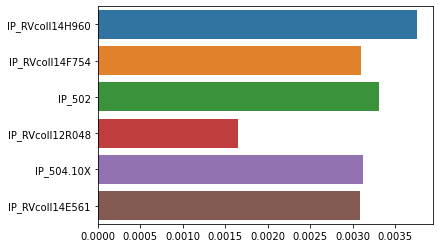

In [98]:
print("mean heterozygosity = ", het_df['het_exons'].mean())
# plot heterozygosity
sns.barplot(x=heterozygosity_exons, y=samples)
plt.show()

We can compute `allel.sequence_diversity` on just the exonic partition of the data using a similar mask for exonic variants that are callable. Note that this mask has to contains a boolean entry for each position of the chromosom:

In [99]:
variant_in_exons_accessible = np.isin(np.arange(0, chrom_length), variants_in_exons_callable_pos_array, assume_unique=True);
len(variant_in_exons_accessible) == chrom_length

True

In [100]:
ac = snp_ga.count_alleles()
diversity = allel.sequence_diversity(snp_pos, ac, is_accessible=variant_in_exons_accessible)
print("Genetic diversity in exons is:", diversity)

Genetic diversity in exons is: 0.005429361747978894


Be careful when using masks to to obtain estimates in windows. E.g. plotting exonic diversity in 50kb windows using the same mask works but is non-sensical: 

The maximum diversity is nan
The SD of pi is nan


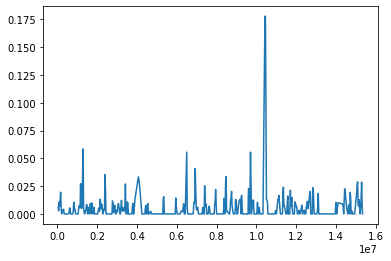

In [101]:
window_size = 50_000
pi, windows, bases, counts = allel.windowed_diversity(snp_pos, snp_ac, size=window_size, start=0, stop=chrom_length, step=int(window_size/2), is_accessible=variant_in_exons_accessible)
x = windows[:,1] - (window_size / 2)
sns.lineplot(x=x, y=pi)
print("The maximum diversity is", max(pi))
print("The SD of pi is", np.std(pi))
plt.show()

<div class="alert alert-block alert-success">
    <b>Exercise 13:</b>
<ul>
How do estimates of heterozygosity and genetic diversity differ between in 3rd codon exon positions, introns and intergenic sequence? Based on these estimates, which genomic partition is least affected by BGS?
<li><b> Hint:</b> Subset the analogous masks for
    </li>
    <ul>
   <li> intron_callable</li>
   <li> intergenic_callable</li>
   <li> tcp_callable</li>
    </ul>
<li>
   Calculate the mean heterozygosity for each of the genomic partitions for each sample</li>
    <ul>
   <li> make sure to subset using the correct mask</li>
   <li> make sure to divide by the correct length</li>
   <li> add your heterozygosity estimates for all samples and genomic partitions to the dataframe <code>het_df</code> </li>
   </ul>
</ul>
   </div>

In [102]:
#SOL
variants_in_introns_callable = variant_intervals.intersect(intron_callable)
variants_in_intergenic_callable = variant_intervals.intersect(intergenic_callable)
variants_in_tcp_callable = variant_intervals.intersect(tcp_callable)

In [103]:
#SOL
variants_in_introns_callable_pos_array = np.array([interval.end for interval in variants_in_introns_callable])
variants_in_intergenic_callable_pos_array = np.array([interval.end for interval in variants_in_intergenic_callable])
variants_in_tcp_callable_pos_array = np.array([interval.end for interval in variants_in_tcp_callable])

In [104]:
#SOL
variant_in_introns_callable_mask = np.isin(snp_pos, variants_in_introns_callable_pos_array, assume_unique=True)
variant_in_intergenic_callable_mask = np.isin(snp_pos, variants_in_intergenic_callable_pos_array, assume_unique=True)
variant_in_tcp_callable_mask = np.isin(snp_pos, variants_in_tcp_callable_pos_array, assume_unique=True)

In [105]:
#SOL
snp_ga_introns = snp_ga[variant_in_introns_callable_mask]
snp_ga_intergenic = snp_ga[variant_in_intergenic_callable_mask]
snp_ga_tcp = snp_ga[variant_in_tcp_callable_mask]

In [107]:
#SOL
heterozygosity_introns = snp_ga_introns.count_het(axis=0) / get_bed_length(intron_callable)
heterozygosity_intergenic = snp_ga_intergenic.count_het(axis=0) / get_bed_length(intergenic_callable)
heterozygosity_tcp = snp_ga_tcp.count_het(axis=0) / get_bed_length(tcp_callable)

mean heterozygosity intron =  0.005874103855841892
mean heterozygosity intergenic=  0.005619439003595558
mean heterozygosity tcp =  0.005522699189752587


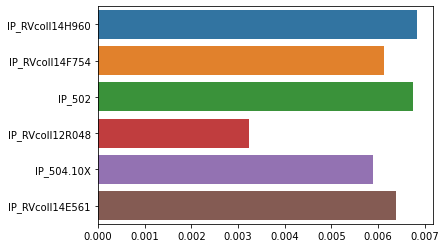

In [108]:
het_df = pd.DataFrame({'samples': samples,'het_exons': heterozygosity_exons,
                       'het_introns': heterozygosity_introns,
                       'het_intergenic': heterozygosity_intergenic,
                       'het_tcp': heterozygosity_tcp})
print("mean heterozygosity intron = ", het_df['het_introns'].mean())
print("mean heterozygosity intergenic= ", het_df['het_intergenic'].mean())
print("mean heterozygosity tcp = ", het_df['het_tcp'].mean())
# plot heterozygosity
sns.barplot(x=heterozygosity_introns, y=samples)
plt.show()

In [110]:
het_df = pd.DataFrame({'samples': samples,'het_exons': heterozygosity_exons,'het_introns': heterozygosity_introns,'het_intergenic': heterozygosity_intergenic,'het_tcp': heterozygosity_tcp})
het_df

,samples,het_exons,het_introns,het_intergenic,het_tcp
0,IP_RVcoll14H960,0.003754,0.006832,0.006486,0.006956
1,IP_RVcoll14F754,0.003092,0.006137,0.006207,0.005834
2,IP_502,0.003314,0.006755,0.005859,0.006183
3,IP_RVcoll12R048,0.001644,0.003241,0.003376,0.002825
4,IP_504.10X,0.003116,0.005886,0.005530,0.005645
5,IP_RVcoll14E561,0.003091,0.006393,0.006260,0.005692


# 3. Exploring variation in genetic diversity between chromosomes 

In [191]:
# in google-sheets